# The Bootstrap with Arch
---

## Comments:
- Arch is a Python library for financial econometrics.
- It also contains an excellent routine for bootstrapping.

Reference: https://bashtage.github.io/arch/bootstrap/bootstrap.html

In [1]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg

import matplotlib.pyplot as plt
import seaborn as sns

from arch.bootstrap import IIDBootstrap
from arch.bootstrap import MovingBlockBootstrap
from arch.bootstrap import StationaryBootstrap

sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(12,9)})

# 1. Bootstrapping i.i.d data

In [2]:
# Function to fit a model and obtain R-squared from the returned RegressionResults instance
# (see https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.RegressionResults.html)

# NOTE! The function below is an example of "currying".
# (see https://composingprograms.com/pages/16-higher-order-functions.html#currying)

def reg_wrapper(formula, stat):
    def _ref_wrapper(data):
        model = sm.formula.ols(formula, data)
        result = model.fit()
        if stat == "params":
            return result.params
        elif stat == "rsquared":
            return result.rsquared
        else:
            raise Exception("No relevant stat.")
    return _ref_wrapper

In [3]:
# For replicability, initialize random state with entropy from random.org

entropy = [877788388, 418255226, 989657335, 69307515]
rs = np.random.RandomState(entropy)

In [4]:
# Model specification
# Let's run a simple linear probability model (LPM) to predict the probability of admission

ucla_formula = "admit ~ 1 + gre + gpa"

In [5]:
# Import UCLA graduate admissions data
# Let's assume for simplicity that the applicant's ability (and hence test scores) are i.i.d.

ucla_data = pd.read_csv("data/ucla.csv")
ucla_data

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4
...,...,...,...,...
395,0,620,4.00,2
396,0,560,3.04,3
397,0,460,2.63,2
398,0,700,3.65,2


In [6]:
# Bootstrapping R-squared with 1000 replications

ucla_bs = IIDBootstrap(ucla_data, random_state=rs)
ucla_bs_results = ucla_bs.apply(reg_wrapper(ucla_formula, "rsquared"), 1000)
ucla_bs_results = pd.DataFrame(ucla_bs_results)
ucla_bs_results.columns = ["rsquared"]
ucla_bs_results

,rsquared
0,0.048202
1,0.037618
2,0.088034
3,0.046655
4,0.051622
...,...
995,0.027778
996,0.081029
997,0.050292
998,0.076507


/home/topher-lo/anaconda3/envs/ec333/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

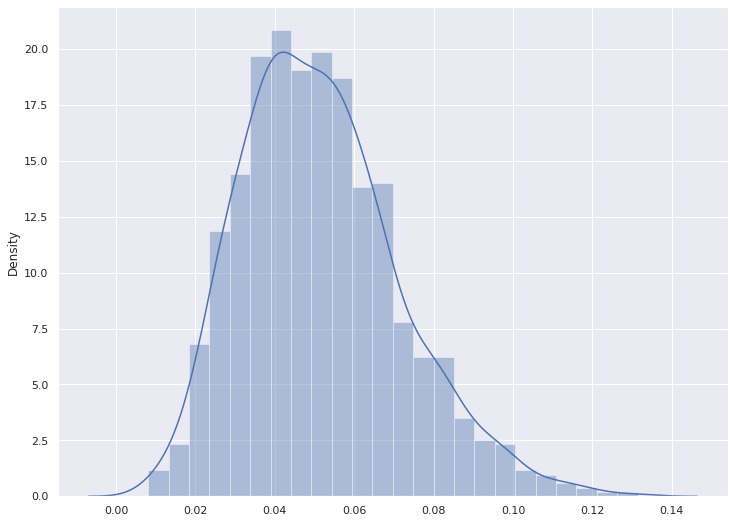

In [7]:
# Fancy plot

sns.distplot(ucla_bs_results)

In [8]:
# Get 95% confidence interval of R-squared

conf_int = np.percentile(ucla_bs_results, [2.5, 97.5])
print('95% confidence interval =', conf_int)

95% confidence interval = [0.02009836 0.0966772 ]


In [9]:
# Bootstrapping coefficients with 1000 replications

ucla_bs = IIDBootstrap(ucla_data, random_state=rs)
ucla_bs_results = ucla_bs.apply(reg_wrapper(ucla_formula, "params"), 1000)
ucla_bs_results = pd.DataFrame(ucla_bs_results)
ucla_bs_results.columns = ["intercept", "gre", "gpa"]
ucla_bs_results

,intercept,gre,gpa
0,-0.741833,0.000496,0.220166
1,-0.948116,0.000586,0.269636
2,-0.754940,0.000699,0.208748
3,-0.625983,0.000652,0.162249
4,-0.546902,0.000553,0.159070
...,...,...,...
995,-0.727214,0.000682,0.190537
996,-0.822142,0.000679,0.216664
997,-0.266637,0.000501,0.087691
998,-0.865377,0.000593,0.259442


/home/topher-lo/anaconda3/envs/ec333/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/topher-lo/anaconda3/envs/ec333/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='gpa', ylabel='Density'>

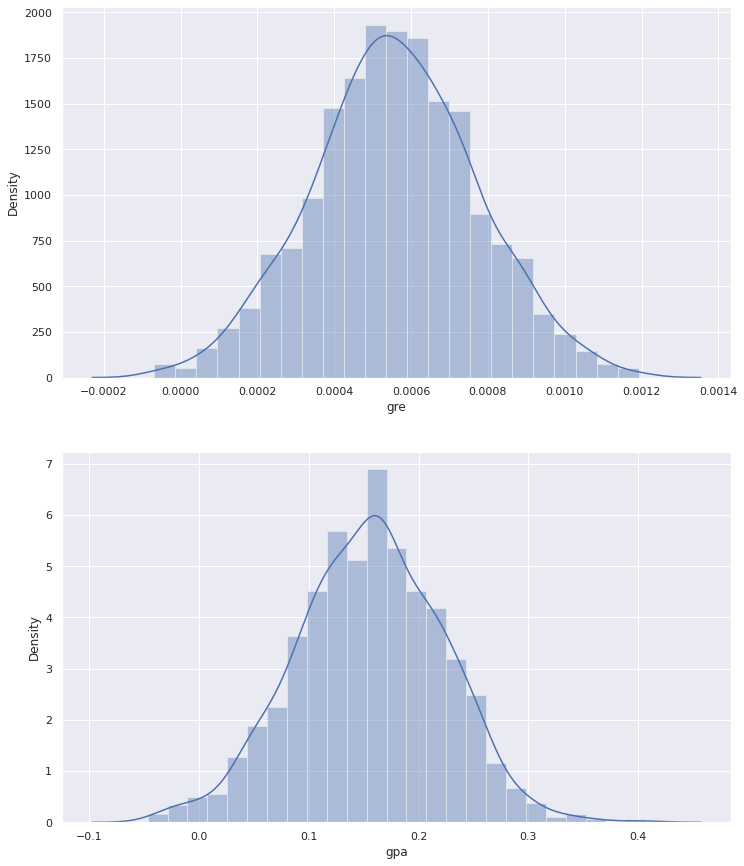

In [10]:
# Fancy plot

fig, axes = plt.subplots(nrows=2, figsize=(12,15))
sns.distplot(ucla_bs_results["gre"], ax=axes[0])
sns.distplot(ucla_bs_results["gpa"], ax=axes[1])

## 1.2. Don't Bootstrap Extreme Order Statistics

/home/topher-lo/anaconda3/envs/ec333/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

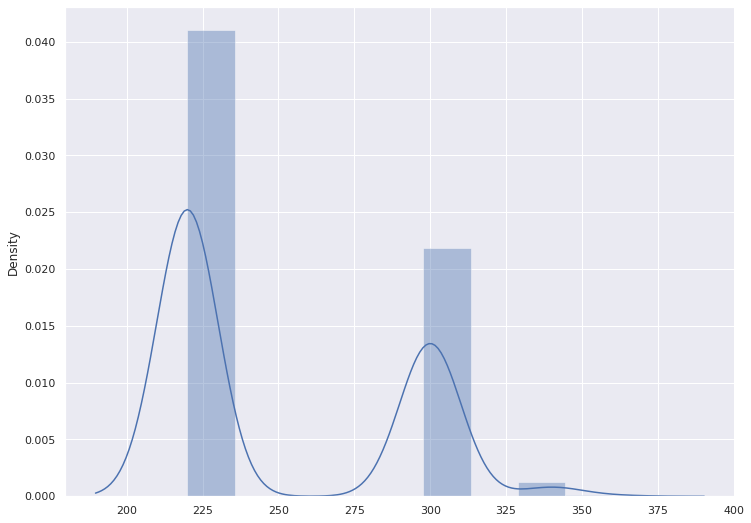

In [11]:
# Example: the minimum

bs_min_example = IIDBootstrap(ucla_data["gre"], random_state=rs)
bs_min_results = bs_min_example.apply(min, 1000)
sns.distplot(bs_min_results)

# 2. Time Series Bootstrap

## Comments:
- The R function tsboot is equivalent to the Python arch's MovingBlockBootstrap.
- Both form blocks of length l (tsboot) / block_size (MovingBlockBootstrap) from the original time series and puts them end-to-end.

References:
- https://www.rdocumentation.org/packages/boot/versions/1.3-25/topics/tsboot
- https://arch.readthedocs.io/en/latest/bootstrap/generated/arch.bootstrap.MovingBlockBootstrap.html

In [12]:
# Import data on lynx trappings in Canada

lynx_data = pd.read_csv("data/lynx.csv", index_col=0)
lynx_data

,time,value
1,1821,269
2,1822,321
3,1823,585
4,1824,871
5,1825,1475
...,...,...
110,1930,662
111,1931,1000
112,1932,1590
113,1933,2657


In [13]:
# Function get mean of dataframe

def get_mean(data):
    return data.mean()

/home/topher-lo/anaconda3/envs/ec333/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

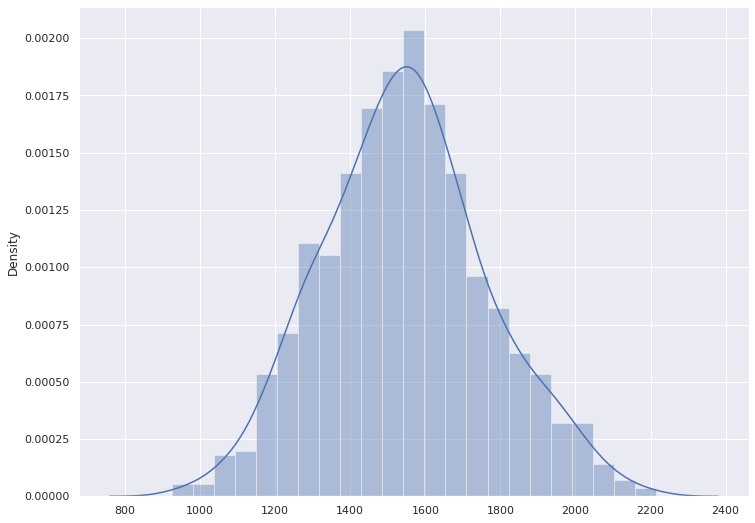

In [14]:
# Time series bootstrap on the mean of lynx trappings
# block size = 5
# number draws = 1000

bs_mean = MovingBlockBootstrap(5, lynx_data["value"], random_state=rs)
bs_mean_results_5_1000 = bs_mean.apply(get_mean, 1000)
sns.distplot(bs_mean_results_5_1000)

/home/topher-lo/anaconda3/envs/ec333/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

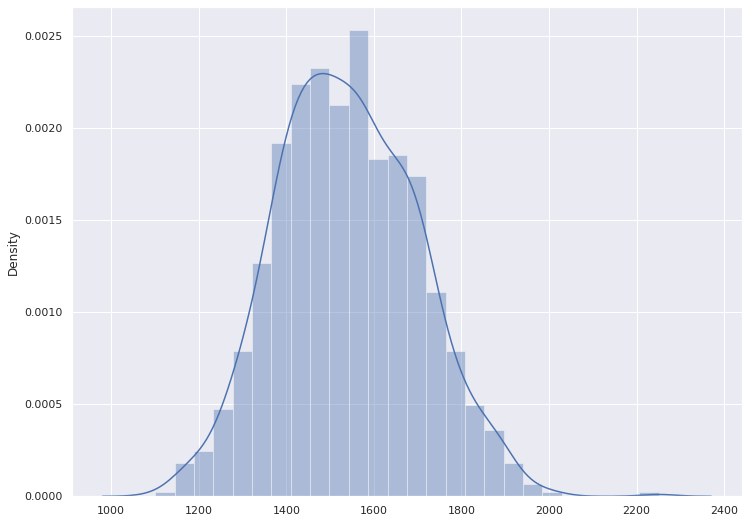

In [15]:
# Check sensitivity!
# Time series bootstrap on the mean of lynx trappings
# block size = 10
# number draws = 1000

bs_mean = MovingBlockBootstrap(10, lynx_data["value"], random_state=rs)
bs_mean_results_10_1000 = bs_mean.apply(get_mean, 1000)
sns.distplot(bs_mean_results_10_1000)

/home/topher-lo/anaconda3/envs/ec333/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

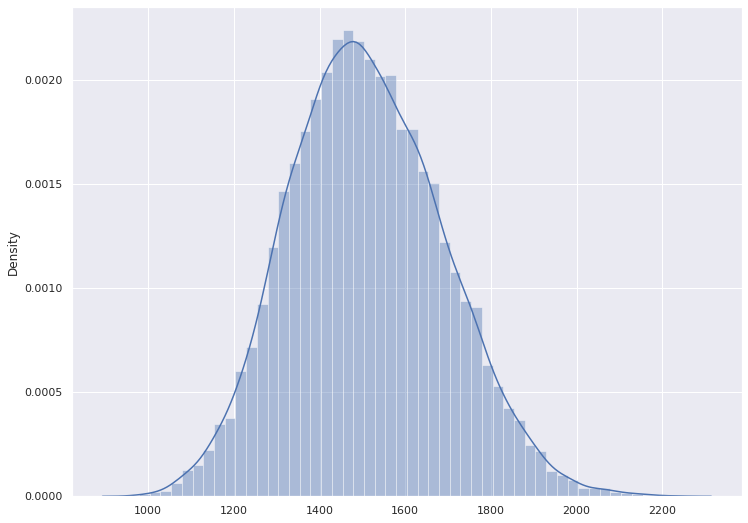

In [16]:
# Check sensitivity!
# Time series bootstrap on the mean of lynx trappings
# block size = 15
# number draws = 10000

bs_mean = MovingBlockBootstrap(15, lynx_data["value"], random_state=rs)
bs_mean_results_15_10000 = bs_mean.apply(get_mean, 10000)
sns.distplot(bs_mean_results_15_10000)

In [17]:
# Sensitivity check

bs_mean_results = [bs_mean_results_5_1000, bs_mean_results_10_1000, bs_mean_results_15_10000]
bs_mean_results = map(pd.DataFrame, bs_mean_results)
bs_mean_results = map(lambda df: df.describe(), bs_mean_results)
bs_mean_results = pd.concat(bs_mean_results, axis=1)
bs_mean_results.columns = ["5_1000", "10_1000", "15_10000"]
bs_mean_results

,5_1000,10_1000,15_10000
count,1000.000000,1000.000000,10000.000000
mean,1546.970360,1540.053412,1510.573468
std,220.694741,159.651599,178.941224
min,925.122807,1100.254386,978.526316
25%,1396.552632,1425.405702,1384.839912
50%,1543.065789,1532.267544,1501.276316
75%,1685.357456,1651.438596,1631.037281
max,2213.991228,2250.298246,2228.929825


# 3. Stationary Time Series Bootstrap

In [18]:
# Take the difference

lynx_data_diff = lynx_data.diff()
lynx_data_diff

,time,value
1,NaN,NaN
2,1.0,52.0
3,1.0,264.0
4,1.0,286.0
5,1.0,604.0
...,...,...
110,1.0,177.0
111,1.0,338.0
112,1.0,590.0
113,1.0,1067.0


/home/topher-lo/anaconda3/envs/ec333/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

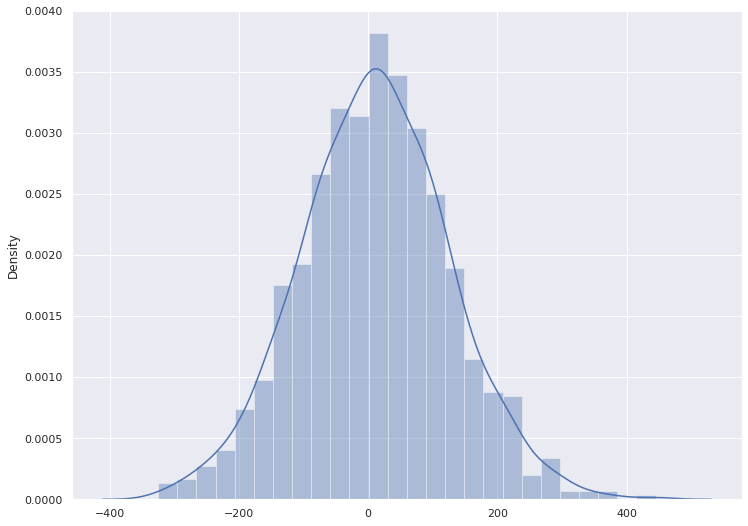

In [19]:
# Time series bootstrap on the mean of lynx trappings
# block size = 5
# number draws = 1000

bs_mean = MovingBlockBootstrap(5, lynx_data_diff["value"], random_state=rs)
bs_mean_results_5_1000 = bs_mean.apply(get_mean, 1000)
sns.distplot(bs_mean_results_5_1000)

/home/topher-lo/anaconda3/envs/ec333/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

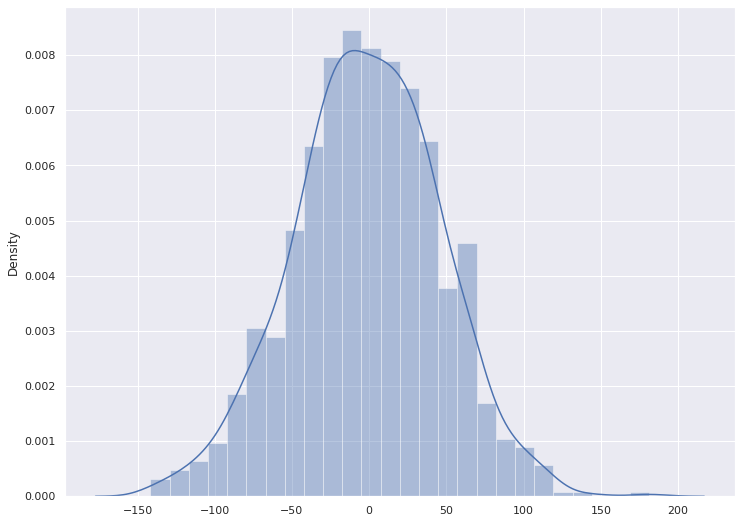

In [20]:
# Time series bootstrap on the mean of lynx trappings
# block size = 10
# number draws = 1000

bs_mean = MovingBlockBootstrap(10, lynx_data_diff["value"], random_state=rs)
bs_mean_results_10_1000 = bs_mean.apply(get_mean, 1000)
sns.distplot(bs_mean_results_10_1000)

/home/topher-lo/anaconda3/envs/ec333/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

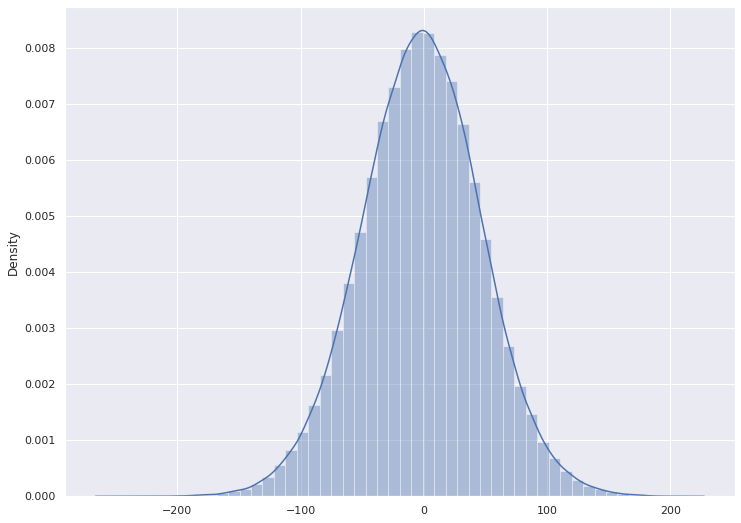

In [21]:
# Time series bootstrap on the mean of lynx trappings
# block size = 10
# number draws = 100000

bs_mean = MovingBlockBootstrap(10, lynx_data_diff["value"], random_state=rs)
bs_mean_results_10_100000 = bs_mean.apply(get_mean, 100000)
sns.distplot(bs_mean_results_10_100000)

/home/topher-lo/anaconda3/envs/ec333/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

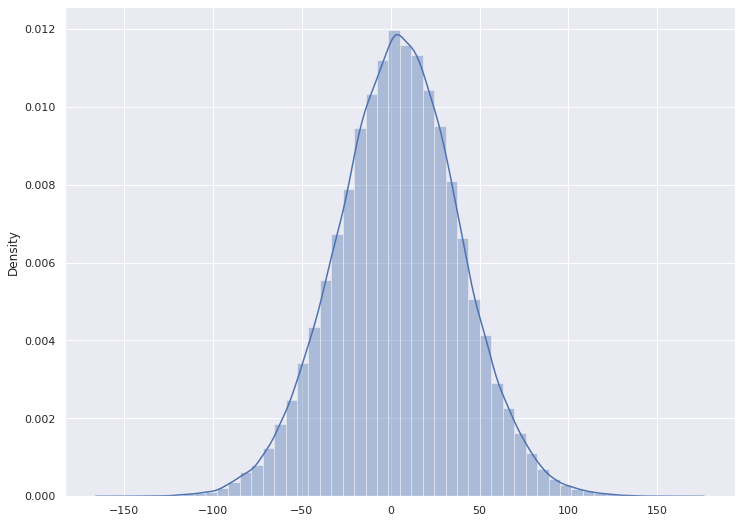

In [22]:
# Time series bootstrap on the mean of lynx trappings
# block size = 30
# number draws = 100000

bs_mean = MovingBlockBootstrap(30, lynx_data_diff["value"], random_state=rs)
bs_mean_results_30_100000 = bs_mean.apply(get_mean, 100000)
sns.distplot(bs_mean_results_30_100000)

In [23]:
# Sensitivity check

bs_mean_results = [bs_mean_results_5_1000, 
                   bs_mean_results_10_1000, 
                   bs_mean_results_10_100000, 
                   bs_mean_results_30_100000]
bs_mean_results = map(pd.DataFrame, bs_mean_results)
bs_mean_results = map(lambda df: df.describe(), bs_mean_results)
bs_mean_results = pd.concat(bs_mean_results, axis=1)
bs_mean_results.columns = ["5_1000", "10_1000", "10_100000", "30_100000"]
bs_mean_results

,5_1000,10_1000,10_100000,30_100000
count,1000.000000,1000.000000,100000.000000,100000.000000
mean,11.087418,-1.466484,-2.172969,4.315182
std,114.443353,47.122300,48.829284,34.622241
min,-325.061404,-141.675439,-251.666667,-155.780702
25%,-66.758772,-31.973684,-34.482456,-18.473684
50%,9.263158,-0.532371,-1.850877,4.587719
75%,86.813596,31.357299,30.373059,27.307018
max,444.754386,181.403509,212.787611,166.070175


/home/topher-lo/anaconda3/envs/ec333/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

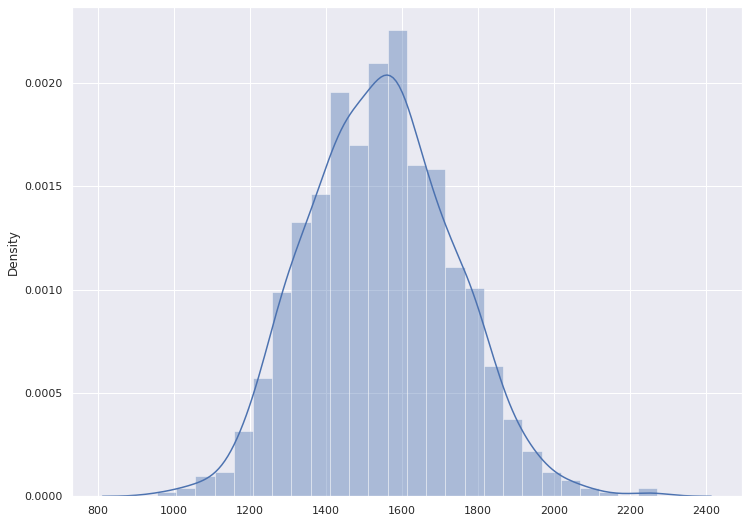

In [24]:
# Let's try Arch's implementation of Politis and Romano's (1994)
# bootstrap with exponentially distributed block sizes
# block size = 5
# number draws = 1000

bs_mean = StationaryBootstrap(5, lynx_data["value"], random_state=rs)
bs_mean_results_sta = bs_mean.apply(get_mean, 1000)
sns.distplot(bs_mean_results_sta)

In [25]:
# Note: lower standard error than the block bootstrap (220.694741)

bs_mean_results_sta = pd.DataFrame(bs_mean_results_sta)
bs_mean_results_sta.columns = ["5_1000_sta"]
bs_mean_results_sta.describe()

,5_1000_sta
count,1000.000000
mean,1543.125535
std,189.608081
min,955.412281
25%,1410.563596
50%,1540.355263
75%,1670.791667
max,2270.254386


In [26]:
# Autoregressive Model

lynx_res = AutoReg(lynx_data_diff["value"].dropna(), lags = 7).fit()
lynx_res.summary()

/home/topher-lo/anaconda3/envs/ec333/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                  value   No. Observations:                  113
Model:                     AutoReg(7)   Log Likelihood                -859.571
Method:               Conditional MLE   S.D. of innovations            804.500
Date:                Fri, 02 Oct 2020   AIC                             13.550
Time:                        17:54:22   BIC                             13.776
Sample:                             7   HQIC                            13.642
                                  113                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -24.2871     78.149     -0.311      0.756    -177.455     128.881
value.L1       0.1403      0.084      1.667      0.095      -0.025       0.305
value.L2      -0.4854      0.083     -5.831      0.000      -0.649      -0.322
value.L3      -0.2054      0.090     -2.284      0.022      -0.382      -0.029
value.L4      -0.3225      0.087     -3.701      0.000      -0.493      -0.152
value.L5      -0.2931      0.090     -3.257      0.001      -0.469      -0.117
value.L6      -0.2141      0.083     -2.575      0.010      -0.377      -0.051
value.L7      -0.4270      0.084     -5.099      0.000      -0.591      -0.263
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.8222           -0.6375j            1.0404           -0.1050
AR.2            0.8222           +0.6375j            1.0404            0.1050
AR.3            0.2234           -1.0872j            1.1099           -0.2178
AR.4            0.2234           +1.0872j            1.1099            0.2178
AR.5           -1.2737           -0.0000j            1.2737           -0.5000
AR.6           -0.6594           -0.9717j            1.1743           -0.3449
AR.7           -0.6594           +0.9717j            1.1743            0.3449
-----------------------------------------------------------------------------
"""